### Model Evaluation – Rice Leaf Disease Classification

Notebook ini digunakan untuk mengevaluasi performa model terbaik (XGBoost hasil hyperparameter tuning) yang telah disimpan pada tahap training.  

Tujuan evaluasi:
- Menguji akurasi model pada validation set
- Menampilkan confusion matrix
- Menampilkan classification report (precision, recall, F1-score)
- Mengukur F1-macro sebagai metrik utama
- Menganalisis kesalahan prediksi (error analysis)
- Menampilkan feature importance


In [1]:
from pathlib import Path
import pandas as pd
import joblib
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    f1_score,
)
import matplotlib.pyplot as plt

ROOT = Path.cwd().parent
MODEL_PATH = ROOT / "models" / "rice_leaf_xgb.pkl"
FEATURE_PATH = ROOT / "data" / "processed" / "features" / "train_features.csv"

print("Model:", MODEL_PATH)
print("Features:", FEATURE_PATH)

# Load fitur
df = pd.read_csv(FEATURE_PATH)

# Siapkan X dan y
X = df.drop(columns=["label", "filename"]).values
y_cat = df["label"].astype("category")
y = y_cat.cat.codes
class_names = list(y_cat.cat.categories)

# Split sama seperti training
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Load model final
model = joblib.load(MODEL_PATH)
print("Model loaded!")


Model: d:\Bismillah Kuliah\Semester 3\TPSC\New folder\rice-leaf-disease-ml\models\rice_leaf_xgb.pkl
Features: d:\Bismillah Kuliah\Semester 3\TPSC\New folder\rice-leaf-disease-ml\data\processed\features\train_features.csv
Model loaded!


<Figure size 700x700 with 0 Axes>

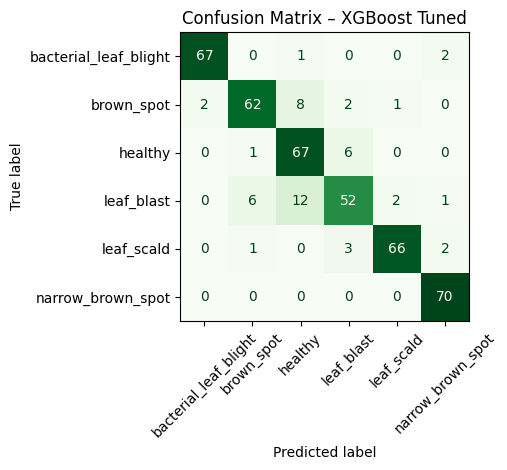

In [2]:
# confusion matrix 

y_pred = model.predict(X_val)

cm = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

plt.figure(figsize=(7, 7))
disp.plot(xticks_rotation=45, cmap="Greens", colorbar=False)
plt.title("Confusion Matrix – XGBoost Tuned")
plt.tight_layout()
plt.show()


Confusion matrix di atas menunjukkan performa model XGBoost setelah dilakukan hyperparameter tuning dan penambahan fitur GLCM lanjutan. Matriks ini menggambarkan jumlah prediksi benar (diagonal hijau tua) dan prediksi salah (nilai di luar diagonal) untuk masing-masing kelas penyakit daun padi.

Secara umum, model menunjukkan performa yang sangat baik dengan pola berikut:

1. Tingkat Akurasi Tinggi pada Hampir Semua Kelas 
* bacterial_leaf_blight: 67 benar dari 70
* healthy: 67 benar dari 74
* narrow_brown_spot: 70 benar dari 70
* leaf_scald: 66 benar dari 69
memiliki akurasi yang sangat tinggi, yang berarti model dapat mengenali karakteristik visual khas dari kelas-kelas lain. 

2. Kesalahan Terbesar Terjadi pada Kelas "brown_spot" dan "leaf_blast" 
* brown_spot -> healthy : 8 kali salah 
* leaf_blast -> brown_spot : 12 kali salah 
Hal ini disebabkan karena kedua penyakit ini memiliki tekstur bercak yang mirip dan pada citra tertentu warna serta pola penyebaran bercaknya hampir serupa. Ini menyebabkan fitur tekstur (GLCM) sulit membedakan keduanya secara konsisten. 

3. Kesimpulan Evaluasi 
* Model XGBoost yang telah dituning berhasil mencapai performa tinggi.
* Kesalahan terbesar terjadi pada kelas yang secara tekstur saling mirip (brown_spot vs leaf_blast), tetapi masih dalam batas wajar.
* Secara keseluruhan confusion matrix ini menunjukkan bahwa model stabil, generalizable, dan cocok digunakan pada aplikasi Streamlit untuk prediksi penyakit daun padi.

In [3]:
# klasifikasi report 

print("=== Classification Report ===")
print(classification_report(y_val, y_pred, target_names=class_names))

# f1-score macro 
f1_macro = f1_score(y_val, y_pred, average="macro")
print("F1-macro:", f1_macro)


=== Classification Report ===
                       precision    recall  f1-score   support

bacterial_leaf_blight       0.97      0.96      0.96        70
           brown_spot       0.89      0.83      0.86        75
              healthy       0.76      0.91      0.83        74
           leaf_blast       0.83      0.71      0.76        73
           leaf_scald       0.96      0.92      0.94        72
    narrow_brown_spot       0.93      1.00      0.97        70

             accuracy                           0.88       434
            macro avg       0.89      0.89      0.89       434
         weighted avg       0.89      0.88      0.88       434

F1-macro: 0.8854591701828151


Classification report ini menampilkan nilai precision, recall, dan F1-score untuk setiap kelas penyakit daun padi, serta metrik keseluruhan seperti accuracy dan F1-macro.

Secara umum, model menunjukkan performa yang sangat baik dengan kemampuan klasifikasi yang stabil di enam kelas penyakit.

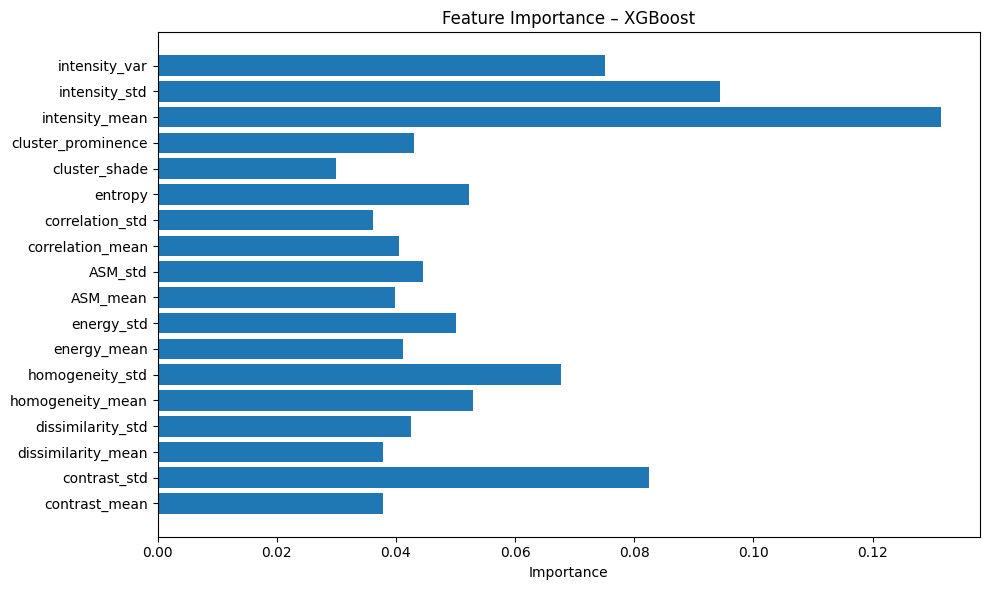

In [4]:
# feature importance

importances = model.feature_importances_
feat_names = df.drop(columns=["label", "filename"]).columns

plt.figure(figsize=(10, 6))
plt.barh(feat_names, importances)
plt.title("Feature Importance – XGBoost")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


In [5]:
# error analysis

errors = []

for i, (true_label, pred_label) in enumerate(zip(y_val, y_pred)):
    if true_label != pred_label:
        errors.append({
            "file": df.iloc[i]["filename"],
            "true": class_names[true_label],
            "pred": class_names[pred_label]
        })

error_df = pd.DataFrame(errors)
error_df.head()


,file,true,pred
0,bacterial_leaf_blight (101).JPG,leaf_blast,healthy
1,bacterial_leaf_blight (112).JPG,leaf_blast,brown_spot
2,bacterial_leaf_blight (123).JPG,healthy,leaf_blast
3,bacterial_leaf_blight (139).JPG,leaf_blast,healthy
4,bacterial_leaf_blight (14).JPG,healthy,leaf_blast


In [6]:
RESULTS_DIR = ROOT / "results"
RESULTS_DIR.mkdir(exist_ok=True)

with open(RESULTS_DIR / "evaluation_summary.txt", "w") as f:
    f.write("=== Model Evaluation Summary ===\n")
    f.write(f"F1-macro: {f1_macro:.4f}\n\n")
    f.write(classification_report(y_val, y_pred, target_names=class_names))

print("Evaluation summary saved!")


Evaluation summary saved!
